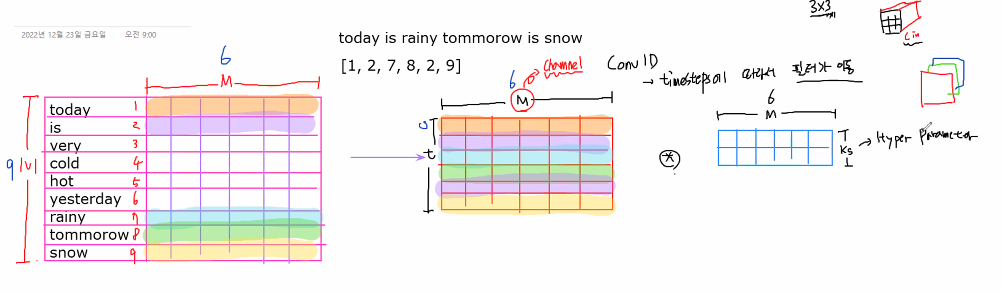

embedding dim M은 이미지처리할때 필터의 채널의 역할을한다!
- 이미지에선 3채널이 RGB정보를 나타내줬음.
- RNN에서 M 은 단어의 정보들을 나타내주기때문에 의미적으로 채널의 역할을 함.
ex) 6차원 단어
  - 1방향 Conv여서 timestep에 따라 필터가 이동

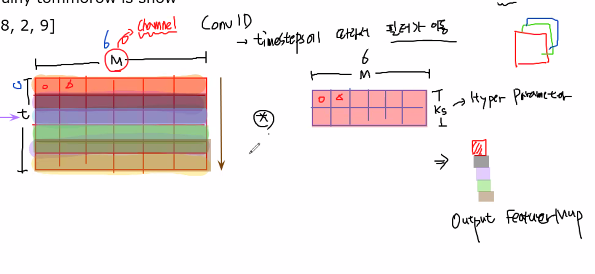

cov연산은 cnn에서랑 똑같음 위에서 아래로 stride에 따라 이동

kernel size의 크기에 따라 단어를 보는 범위가 달라진다! N-gram과 비슷

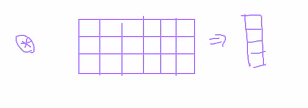

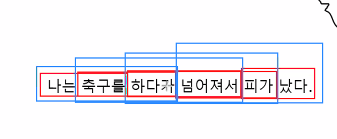

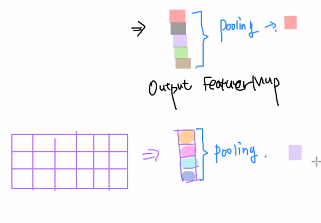

- 요약은 풀링으로 하면됨
커널사이즈를 2로했을 땐 대표값이 빨간색이나왔는데

커널사이즈를 3으로늘리면 보라색이나오네?

관점이 여러개가됨. 하나의 문장을 바라보는 시야를 넓혔다 줄였다 할수있음 

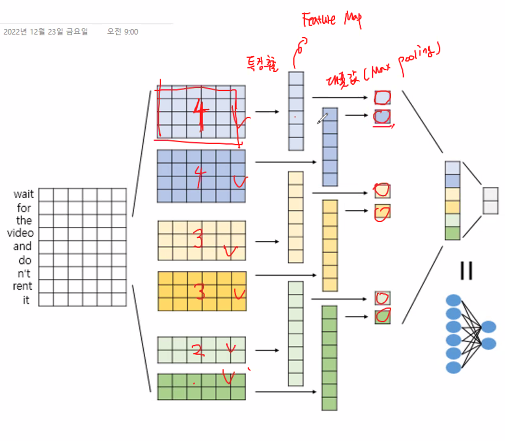

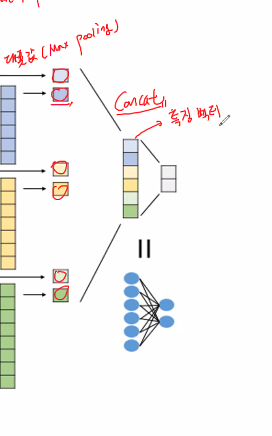

concat하면 각 필터로봤을때의 특징들의 벡터가 만들어짐.

그 뒤로는 이진분류면 FCL을하든 하면됨

# 직접 구현해보자

In [1]:
import pickle

with open("./X_train_padded.pkl", 'rb') as f:
  X_train_padded = pickle.load(f)

with open("./t_train.pkl", 'rb') as f:
  y_train = pickle.load(f)

In [2]:
X_train_padded[:3]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,    66,   469,
           29,   255,   676],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,   940,   470,    55,   622,     3,   230,  1464,    39,
          971,   693,    32],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   439, 16134,     1,  2326,  5642,     4,
          240,    23,    21]], dtype=int32)

# 하이퍼 파라미터 설정

In [3]:
len(X_train_padded)

145393

In [4]:
vocab_size = 19417

In [7]:
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Input

In [8]:
# functional API로 만들어보자

inputs = Input(shape=(30,))  # 어제 문장의 길이를 30으로 padding해놔서
net = Embedding(vocab_size, 128, input_length=30)(inputs)

net.shape # Lookup Table의 shape

TensorShape([None, 30, 128])

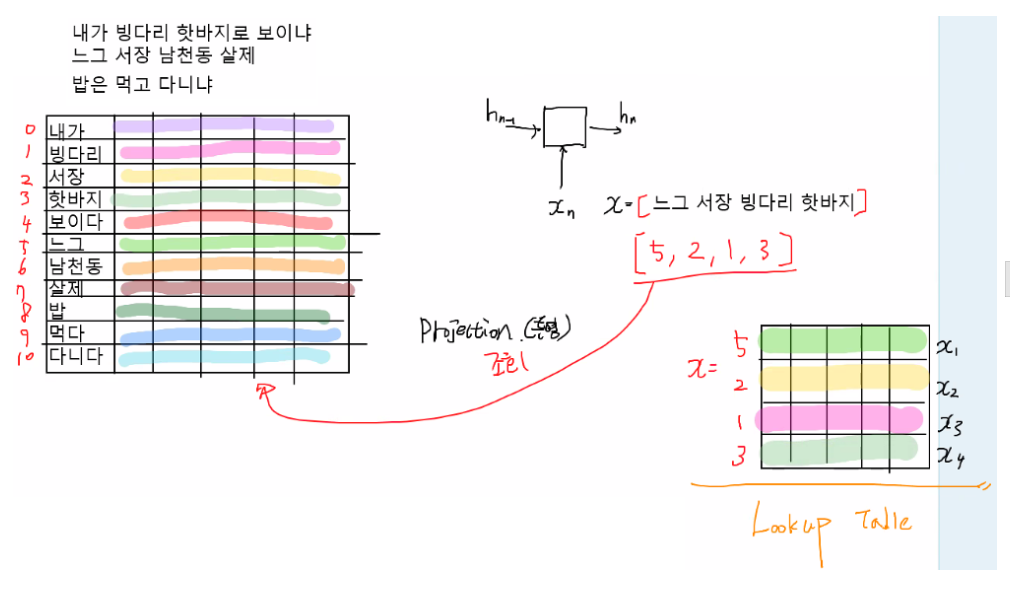

In [10]:
# 각 사이즈별 필터의 '개수'
num_filters=64

# 커널 사이즈 리스트
kernel_size_list = [4, 4, 3, 3, 2, 2]

for kernel_size in kernel_size_list:
  # 합성곱 연산
  conv = Conv1D(filters = num_filters, kernel_size = kernel_size, padding='valid', activation='tanh', strides=1) 
  # 자연어처리에선 padding잘 안넣움
  # 활성화함수 relu해도됨

  conv_result = conv(net)  # net 은 lookup table이었음.
  print("Conv1D Result Shape (kernel_size : {}) : {}".format(kernel_size, conv_result.shape))

# 27 : output feature map의 크기 , 64 : 채널의 크기

Conv1D Result Shape (kernel_size : 4) : (None, 27, 64)
Conv1D Result Shape (kernel_size : 4) : (None, 27, 64)
Conv1D Result Shape (kernel_size : 3) : (None, 28, 64)
Conv1D Result Shape (kernel_size : 3) : (None, 28, 64)
Conv1D Result Shape (kernel_size : 2) : (None, 29, 64)
Conv1D Result Shape (kernel_size : 2) : (None, 29, 64)


똑같은 lookup table이 각각 들어가는거임. 연속적으로 > >  > 넣는게아니라

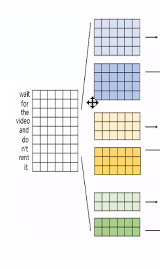

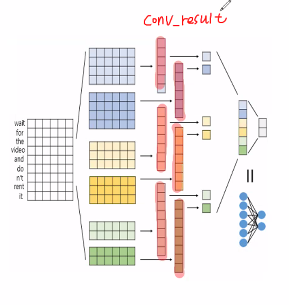

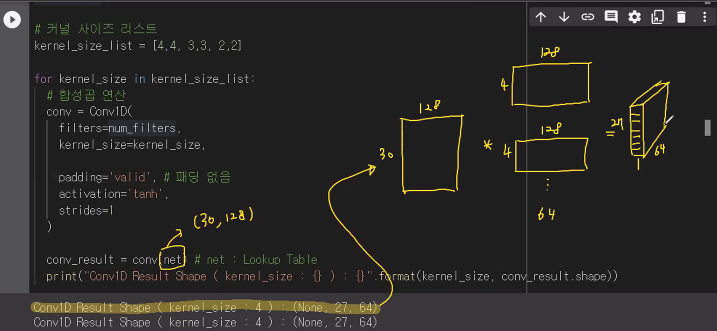

## 풀링으로 대표값 뽑기

In [12]:
# 각 사이즈별 필터의 '개수'
num_filters=64

# 커널 사이즈 리스트
kernel_size_list = [4, 4, 3, 3, 2, 2]

for kernel_size in kernel_size_list:
  # 합성곱 연산
  conv = Conv1D(filters = num_filters, kernel_size = kernel_size, padding='valid', activation='tanh', strides=1) 
  # 자연어처리에선 padding잘 안넣움
  # 활성화함수 relu해도됨

  conv_result = conv(net)  # net 은 lookup table이었음.
  print("Conv1D Result Shape (kernel_size : {}) : {}".format(kernel_size, conv_result.shape))

  # 풀링
  pool_result = GlobalMaxPooling1D()(conv_result)
  print("Pool Result Shape ( kernel_size : {} ) : {}".format(kernel_size, pool_result.shape))

  print("="*50)

Conv1D Result Shape (kernel_size : 4) : (None, 27, 64)
Pool Result Shape ( kernel_size : 4 ) : (None, 64)
Conv1D Result Shape (kernel_size : 4) : (None, 27, 64)
Pool Result Shape ( kernel_size : 4 ) : (None, 64)
Conv1D Result Shape (kernel_size : 3) : (None, 28, 64)
Pool Result Shape ( kernel_size : 3 ) : (None, 64)
Conv1D Result Shape (kernel_size : 3) : (None, 28, 64)
Pool Result Shape ( kernel_size : 3 ) : (None, 64)
Conv1D Result Shape (kernel_size : 2) : (None, 29, 64)
Pool Result Shape ( kernel_size : 2 ) : (None, 64)
Conv1D Result Shape (kernel_size : 2) : (None, 29, 64)
Pool Result Shape ( kernel_size : 2 ) : (None, 64)


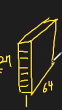

conv_result

# 완성본

In [13]:
# 각 사이즈별 필터의 '개수'
num_filters=64

# 마지막에 concat해야하므로 결과 모아두기
conv_pool_result_list = []

# 커널 사이즈 리스트
kernel_size_list = [4, 4, 3, 3, 2, 2]

for kernel_size in kernel_size_list:
  # 합성곱 연산
  conv = Conv1D(filters = num_filters, kernel_size = kernel_size, padding='valid', activation='tanh', strides=1) 
  # 자연어처리에선 padding잘 안넣움
  # 활성화함수 relu해도됨

  conv_result = conv(net)  # net 은 lookup table이었음.
  print("Conv1D Result Shape (kernel_size : {}) : {}".format(kernel_size, conv_result.shape))

  # 풀링
  pool_result = GlobalMaxPooling1D()(conv_result)
  print("Pool Result Shape ( kernel_size : {} ) : {}".format(kernel_size, pool_result.shape))

  print("="*50)

  conv_pool_result_list.append(pool_result)

Conv1D Result Shape (kernel_size : 4) : (None, 27, 64)
Pool Result Shape ( kernel_size : 4 ) : (None, 64)
Conv1D Result Shape (kernel_size : 4) : (None, 27, 64)
Pool Result Shape ( kernel_size : 4 ) : (None, 64)
Conv1D Result Shape (kernel_size : 3) : (None, 28, 64)
Pool Result Shape ( kernel_size : 3 ) : (None, 64)
Conv1D Result Shape (kernel_size : 3) : (None, 28, 64)
Pool Result Shape ( kernel_size : 3 ) : (None, 64)
Conv1D Result Shape (kernel_size : 2) : (None, 29, 64)
Pool Result Shape ( kernel_size : 2 ) : (None, 64)
Conv1D Result Shape (kernel_size : 2) : (None, 29, 64)
Pool Result Shape ( kernel_size : 2 ) : (None, 64)


In [14]:
conv_pool_result_list

[<KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'global_max_pooling1d_12')>,
 <KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'global_max_pooling1d_13')>,
 <KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'global_max_pooling1d_14')>,
 <KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'global_max_pooling1d_15')>,
 <KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'global_max_pooling1d_16')>,
 <KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'global_max_pooling1d_17')>]

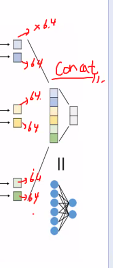

이제 concat하자

In [15]:
from tensorflow.keras.layers import Concatenate

concat_result = Concatenate()(conv_pool_result_list)
print("Concat Result Shape : {}".format(concat_result.shape))

# 64개짜리를 6개이었으므로 384

Concat Result Shape : (None, 384)


In [16]:
# Fully connected 구현
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

net = Dense(128, activation='tanh')(concat_result)

output = Dense(1, activation = 'sigmoid')(net)

model = Model(inputs, output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 128)      2485376     ['input_1[0][0]']                
                                                                                                  
 conv1d_18 (Conv1D)             (None, 27, 64)       32832       ['embedding[0][0]']              
                                                                                                  
 conv1d_19 (Conv1D)             (None, 27, 64)       32832       ['embedding[0][0]']              
                                                                                              

In [19]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['acc']
)
model.fit(
    X_train_padded,
    y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2
)

Epoch 1/10
1818/1818 [==============================] - 25s 9ms/step - loss: 0.3758 - acc: 0.8292 - val_loss: 0.3332 - val_acc: 0.8557
Epoch 2/10
1818/1818 [==============================] - 15s 8ms/step - loss: 0.2494 - acc: 0.8987 - val_loss: 0.3416 - val_acc: 0.8569
Epoch 3/10
1818/1818 [==============================] - 15s 8ms/step - loss: 0.1409 - acc: 0.9485 - val_loss: 0.4164 - val_acc: 0.8478
Epoch 4/10
1818/1818 [==============================] - 15s 8ms/step - loss: 0.0758 - acc: 0.9735 - val_loss: 0.5161 - val_acc: 0.8432
Epoch 5/10
1818/1818 [==============================] - 15s 8ms/step - loss: 0.0504 - acc: 0.9820 - val_loss: 0.6272 - val_acc: 0.8362
Epoch 6/10
1818/1818 [==============================] - 15s 8ms/step - loss: 0.0402 - acc: 0.9849 - val_loss: 0.7383 - val_acc: 0.8304
Epoch 7/10
1818/1818 [==============================] - 15s 8ms/step - loss: 0.0369 - acc: 0.9860 - val_loss: 0.7601 - val_acc: 0.8361
Epoch 8/10
1818/1818 [==============================] -

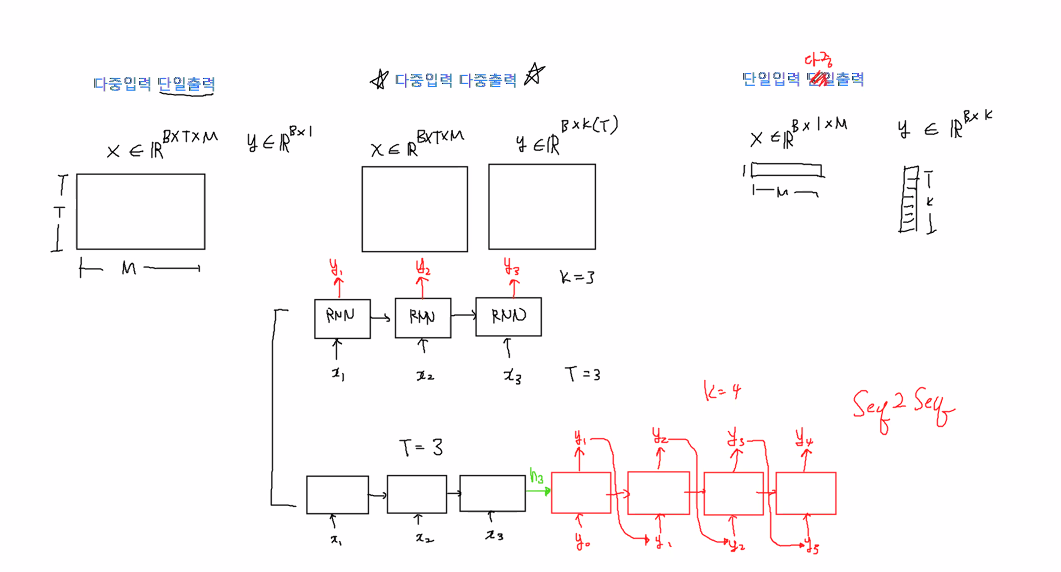

보통 윗칸처럼 K=T 3같은데

## 빨간모델있는게 2014년에 등장한 가장많이사용하는 Seq2Seq💜
- 입력은 3갠데 T=3, 출력은 K=4
- 다를 수도 있다

### - 다중입력, 다중출력 💙💙
- 빅스비, 시리같은거
- 번역기 챗봇
- 보라색 개체인식 네트워크라고함

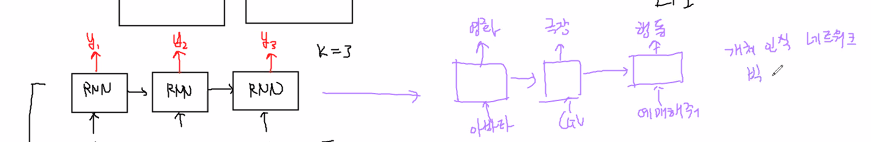

챗봇 종류 2개
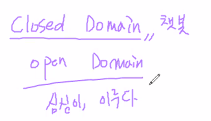

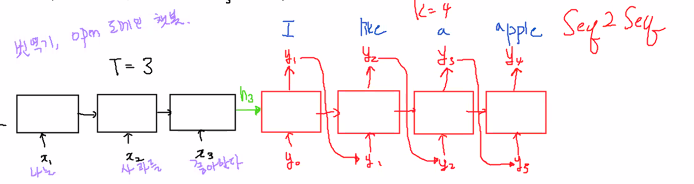

# BPTT (시간 펼침 역전파)
- back propagation through time 
- 시간의 흐름을 거꾸로 타는 역전파!


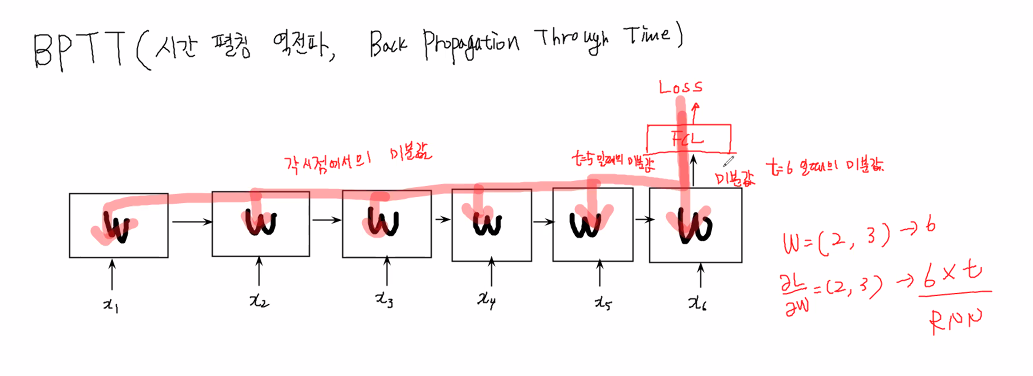

RNN은 미분값을 저장할 공간이 '가중치개수 X t'
- 메모리공간 차지하기때무네 ran gpu좋은거 써야함
- 업데이트 되는 W는 한벌밖에 없지만

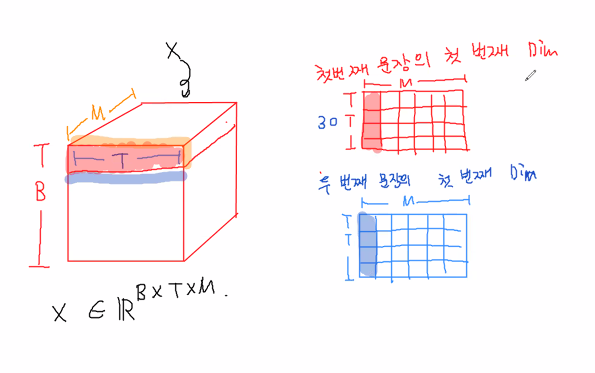

prepadding쓰면 이러케됨

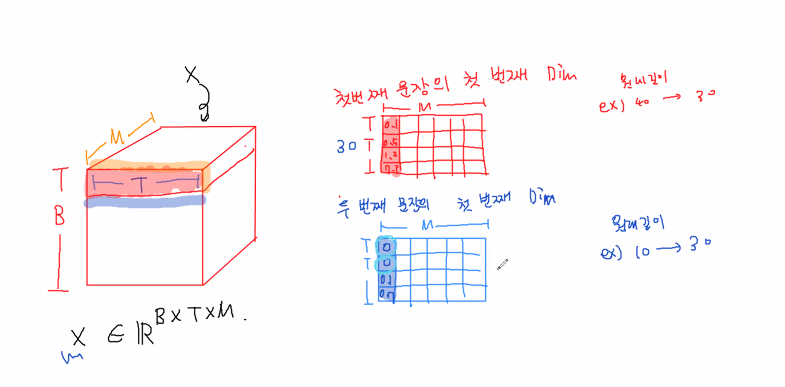

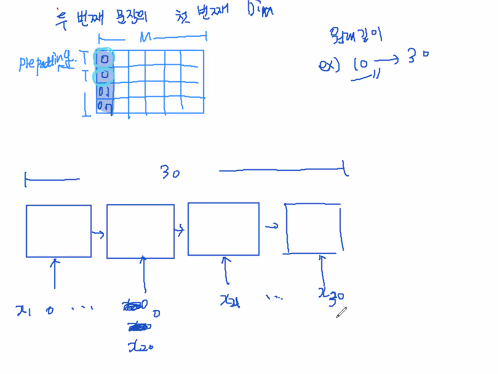

패딩때매 x1~20=0 이러케 들어감

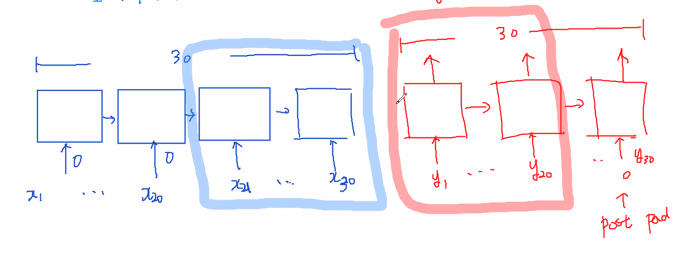

y출력부분에선 post패딩 써줘야!

# shape복습

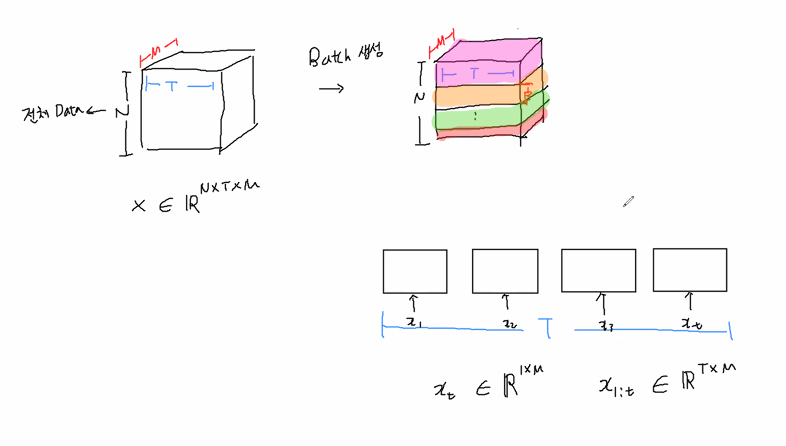

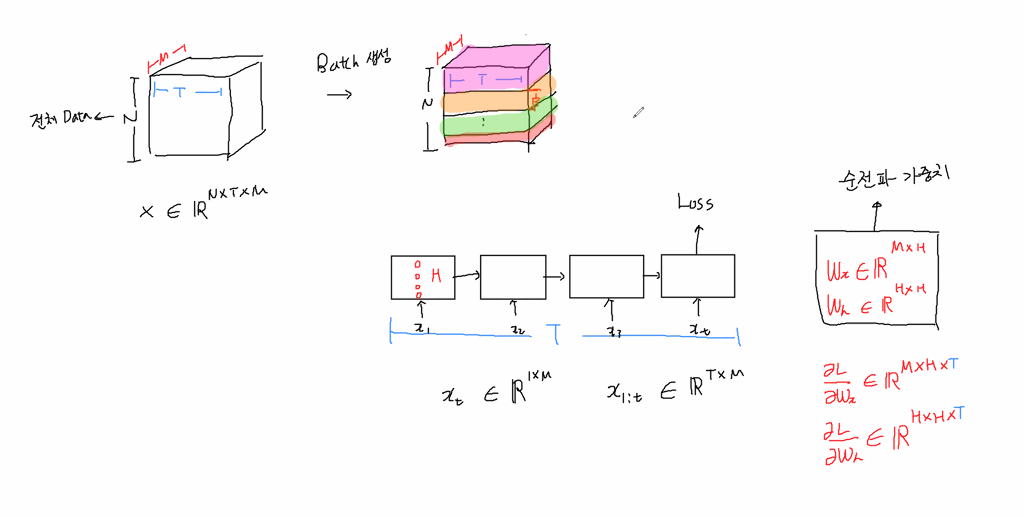

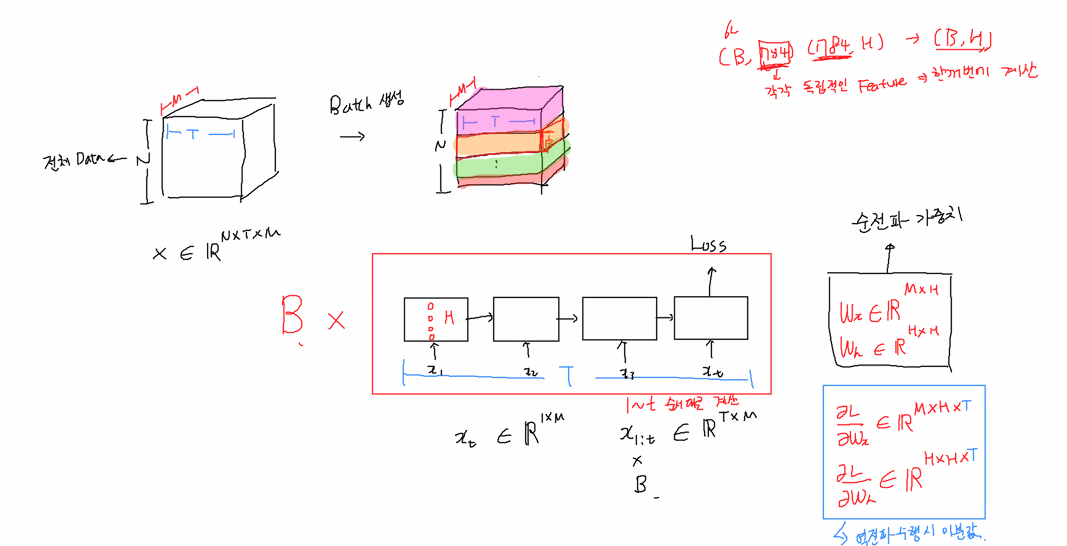

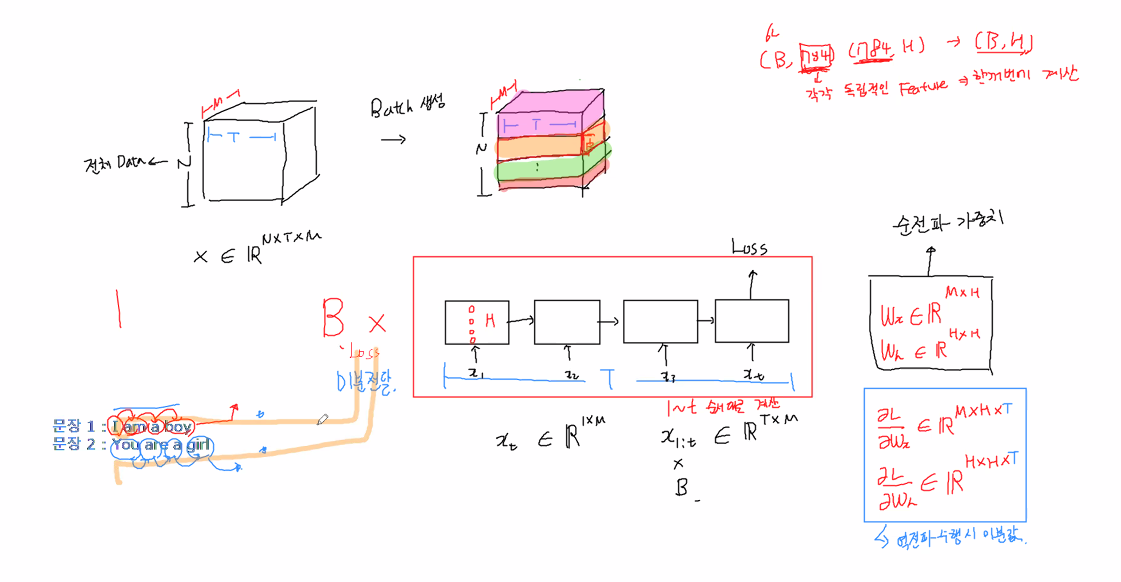

loss에 대한 미분 문장(데이터)별로'따로따로' 전달해야함
- 이미지할때는 그냥 싹 한번에 배치별로 loss전달했지마는

## 최종 가중치 개수 
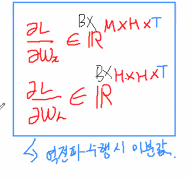

B랑 T때문에 메모리 조온나필요

T를 자른다

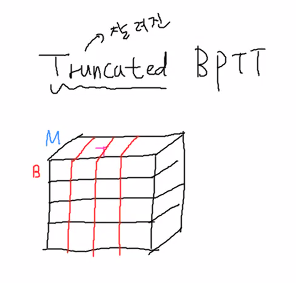

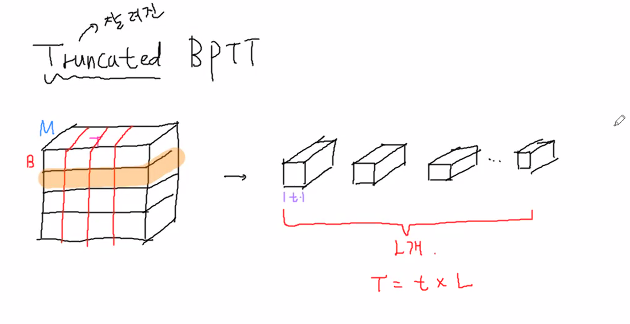

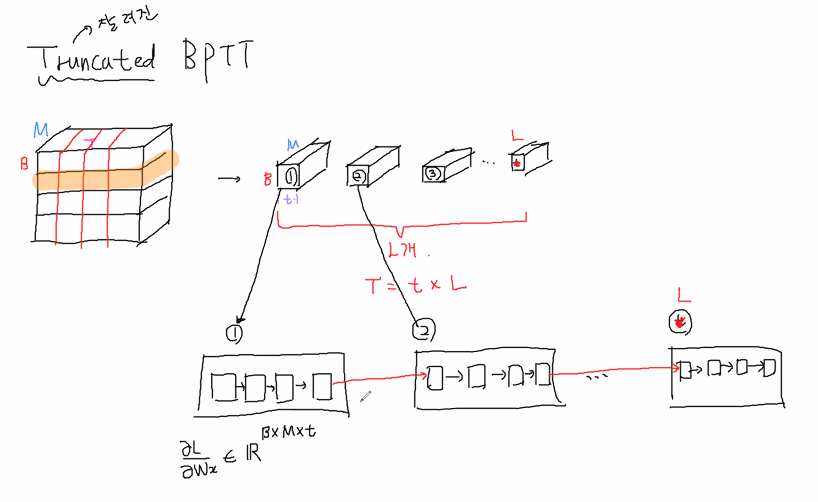

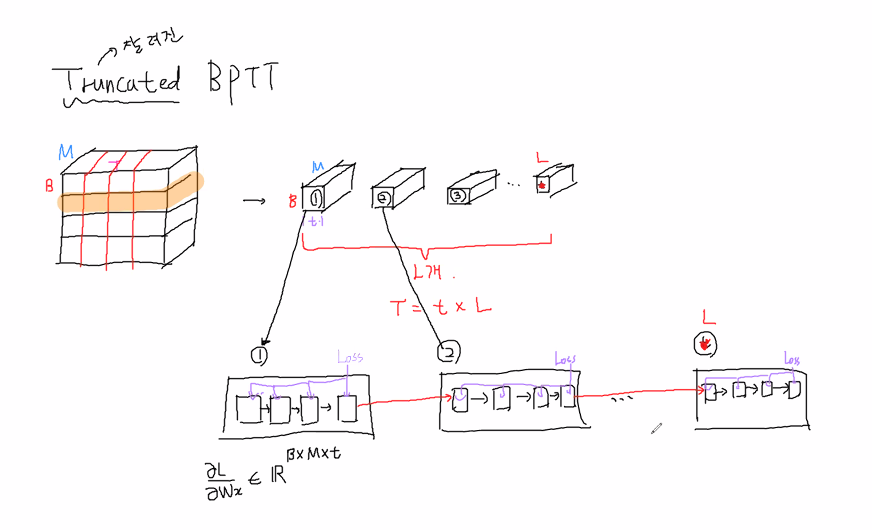

따로따로 loss됨
메모리 1/L만큼 작아짐 ㅎ

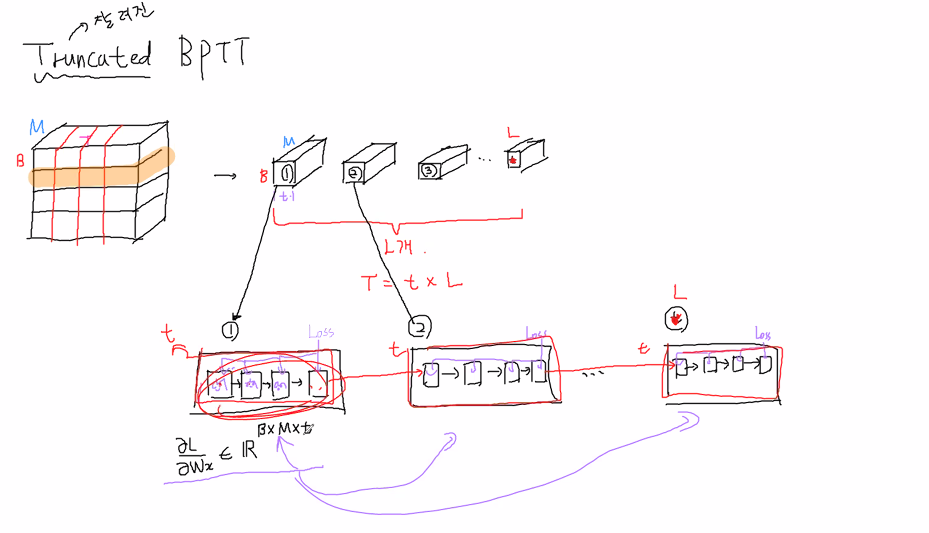

t개 단어씩 하고 역전파, t개 단어씩하고 역전파

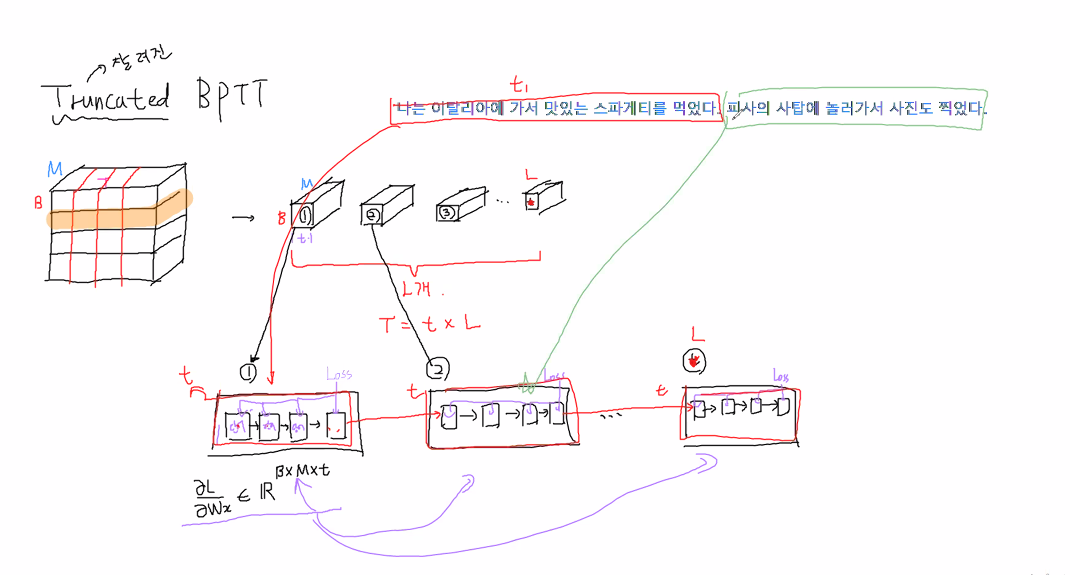

이거처럼 끊어서 학습

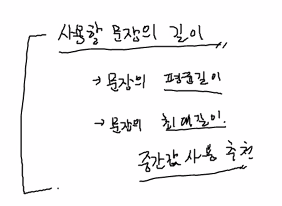

너무잘게짤라도안됨.
문장의 평균길이, 중간값확인

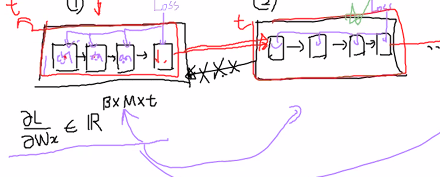